**Write the names of all group members (max. 5 members)**:
- Nils, Johnson
- Matteo, Bodmer
- Jonas, Isler
- Lucas, Gimeno
- Hai-Yen, Van

When submitting your work, please follow closely the template below.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

**Problem Statement**

We need to check that $S_t = s_0 \exp\left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black–Scholes Stochastic Differential Equation (SDE) (with $r=0$): $$dS_t = \sigma S_t dW_t$$

**Itô's Lemma:** [source](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma)

>For 
>$$
>d X_t = \mu_t dt + \sigma_t d B_t
>$$
>and any twice differentiable scalar function $f(t, x)$ of two real variables $t$ and $x$, one has
>$$
>df(t, X_t) = \left( \frac{\partial f}{\partial t} + \mu_t \frac{\partial f}{\partial x} + \frac{\sigma_t^2}{2} \frac{\partial^2 f}{\partial x^2} \right) dt + \sigma_t \frac{\partial f}{\partial x} d B_t.
>$$

**Solution by Derivation:**

Let $f(t, W_t) = s_0 \exp\left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)=S_t$.

According to Itô's Lemma:

$$
dS_t = \left(\frac{\partial f}{\partial t}  + \frac{1}{2} \frac{\partial^2 f}{\partial W_t^2} \right)dt + \frac{\partial f}{\partial W_t} dW_t
$$

Calculating the partial derivatives:

1.  $\frac{\partial f}{\partial t} = s_0 \exp\left( \sigma W_t - \frac{1}{2} \sigma^2 t \right) \cdot \left(-\frac{1}{2}\sigma^2\right) = -\frac{1}{2}\sigma^2 S_t$
2.  $\frac{\partial f}{\partial W_t} = s_0 \exp\left( \sigma W_t - \frac{1}{2} \sigma^2 t \right) \cdot \sigma = \sigma S_t$
3.  $\frac{\partial^2 f}{\partial W_t^2} = \sigma \cdot \frac{\partial f}{\partial W_t} = \sigma^2 S_t$

Then:

$$
dS_t = \left( -\frac{1}{2}\sigma^2 S_t \right) dt + \sigma S_t dW_t + \frac{1}{2} (\sigma^2 S_t) dt
 = \sigma S_t dW_t
$$

This matches the Black–Scholes SDE (with $r=0$).

### Question 1.b - Generate dataset

In [2]:
def data_gen(N,S0,T,Sigma,paths):

    # time step
    dt = T/N

    # Generate Gaussian random variables: shape (paths, N)
    Z = torch.randn(paths, N)

    # initialize Matrix for paths
    S = torch.zeros(paths,N+1)
    S[:,0] = S0

    for i in range(N):

        S[:,i+1] = S[:,i]*torch.exp(-Sigma**2/2 * dt + Sigma*torch.sqrt(torch.tensor(dt))*Z[:,i])
    
    return S

# Generate the training set
n = 30
s0 = 1
t = 30/365
sigma = 0.5
paths_training = 100000

train = data_gen(n,s0,t,sigma,paths_training)

dataset_train = TensorDataset(train)

# Generate the test set
paths_test = 10000

test = data_gen(n,s0,t,sigma,paths_test)

dataset_test = TensorDataset(test)

### Question 1.c - Model implementation

In [3]:
# Implement the deep hedging model

# number of NN 
N = 30

# Number of neurons in hidden layers
nh1 = 32 # first hidden layer
nh2 = 32 # second hidden layer

# N number of NN
networks = nn.ModuleList([
    nn.Sequential(
        nn.Linear(1, nh1),
        nn.ReLU(),
        nn.Linear(nh1, nh2),
        nn.ReLU(),
        nn.Linear(nh2, 1)
    )
    for _ in range(N)
])

### Question 1.d - Model training

  0%|          | 0/100 [00:00<?, ?it/s]

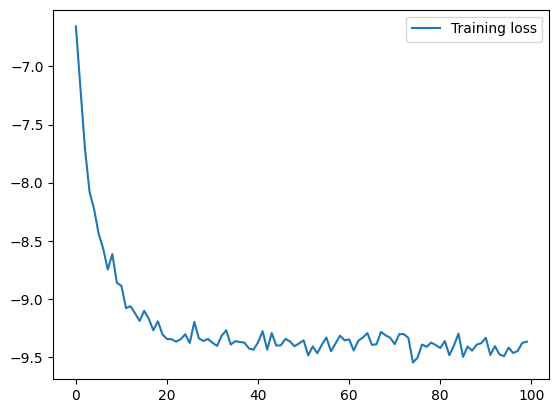

In [4]:
# Implement the payoff function of a call option
def call_payoff(ST):
    K = 1
    return torch.clamp(ST-K,min=0.0)

# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
def call_value(St,t):
    
    K = 1
    T = 30/365
    sigma = 0.5
    r = 0

    d_plus = 1/(sigma*torch.sqrt(torch.tensor(T-t))) * (torch.log(St/K)+(r + sigma**2/2)*(T-t))
    d_minus = d_plus - sigma*torch.sqrt(torch.tensor((T-t)))
    
    normal = torch.distributions.Normal(0, 1)

    value = normal.cdf(d_plus)*St - normal.cdf(d_minus)*K*torch.exp(torch.tensor(-r*(T-t)))

    return value

rn_price = call_value(train[:, 0], 0.0)

# Train the model

# Define training hyperparameters
n_epochs = 100
lr = 1e-3 # learning rate
batch_size = 1000
milestones = [75]

# with chain we can pass all the parameters if the network
# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
optimizer = torch.optim.AdamW(networks.parameters(), lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Create a batch loader from the dataset
loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

### Training

# Computes ∑ H_tj(S_tj) * (S_{t_{j+1}} - S_{t_j})
def hedge_sum(networks, S):
    hedge = torch.zeros(S.shape[0])
    for j, net in enumerate(networks):
        Hj = net(S[:, j].unsqueeze(1)).squeeze()  # Hedge ratio for all paths
        hedge += Hj * (S[:, j+1] - S[:, j])
    return hedge

# computes loss function
def loss_fn(networks,S,rn_price):
    payoff = call_payoff(S[:,-1])
    hedge_val = hedge_sum(networks,S)
    return torch.mean((payoff-rn_price-hedge_val)**2)


losses = torch.empty(n_epochs)
training_loop = tqdm(range(n_epochs)) 

for epoch in training_loop:
    
    # At each epoch iterate over batches
    for (batch,) in loader:
        # compute training loss on batch
        loss = loss_fn(networks, batch, rn_price.mean())
        # compute gradient of training loss wrt parameters
        loss.backward()
        # do one gradient step
        optimizer.step()
        # reset the computational graph        
        optimizer.zero_grad()
        
    
    # Print loss in the progression bar
    training_loop.set_postfix(loss = loss.item())
    
    # decrease learning rate according to scheduler's settings
    scheduler.step()

    # save training loss for plotting
    losses[epoch] = loss.item()

plt.plot(torch.log(losses), label='Training loss')
plt.legend()
plt.show()

### Question 1.e - Model evaluation

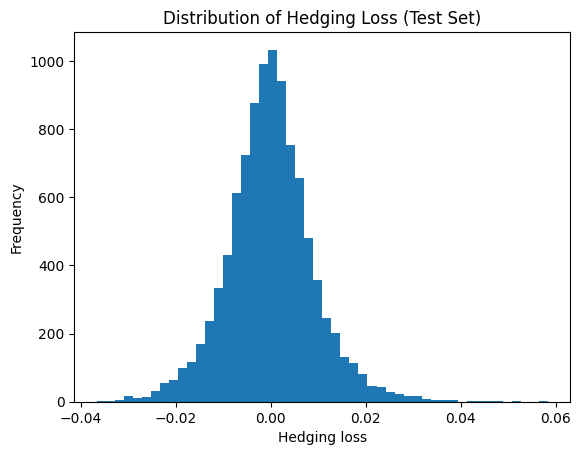

Mean hedging loss: -0.000031
Std of hedging loss: 0.009136
Mean squared hedging loss: 0.000083


In [5]:
# Evaluate the hedging losses on the test set
def pathwise_loss(networks, S, rn_price):
    payoff = call_payoff(S[:, -1])
    hedge_val = hedge_sum(networks, S)
    return payoff - rn_price - hedge_val

# turn off gradient tracking for evaluation
with torch.no_grad():
    # vector with one error per simulated path
    errors = pathwise_loss(networks, test, rn_price.mean()) 
    losses_test = errors**2

# Plot a histogram of the hedging losses and print mean and standard deviation
plt.hist(errors.numpy(), bins=50)
plt.title("Distribution of Hedging Loss (Test Set)")
plt.xlabel("Hedging loss")
plt.ylabel("Frequency")
plt.show()

# Compute mean and std of squared loss
print(f"Mean hedging loss: {errors.mean().item():.6f}")
print(f"Std of hedging loss: {errors.std().item():.6f}")
print(f"Mean squared hedging loss: {losses_test.mean().item():.6f}")

### Question 1.f(i) - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \ldots
\end{align*}

No points for solutions without explicit derivation.

![Proof](1_f_derivation.JPG)

We start from the Black–Scholes call price:

$$
C(S_t,\varepsilon)
= \mathbb{N}(d_+) S 
- \mathbb{N}(d_-) K e^{-r(T-t)}.
$$

where

$$
d_+ 
= \frac{1}{\sigma \sqrt{T-t}}
\left( \ln\left(\frac{S}{K}\right)
+ \left(r + \tfrac12 \sigma^2\right)(T-t) \right),
$$

and

$$
d_- = d_+ - \sigma\sqrt{T-t}.
$$

The CDF is

$$
\mathbb{N}(x)
= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-z^2/2}\, dz.
$$

Using the **Leibniz rule**:

$$
\frac{d}{dx} \int_a^{g(x)} f(t)\, dt
= f(g(x))\, g'(x).
$$

and the fact that the derivative of the CDF is the pdf,

$$
\mathbb{N}'(x)
= \frac{1}{\sqrt{2\pi}} e^{-x^2/2}.
$$

---

## Derivatives of $d_+$ and $d_-$

We compute:

$$
d_+ 
= \frac{1}{\sigma \sqrt{T-t}}
\left( \ln\left(\frac{S}{K}\right)
+ \left(r + \tfrac12 \sigma^2\right)(T-t) \right).
$$

Only the $\ln(S/K)$ term depends on $S$, so

$$
\frac{\partial}{\partial S} \ln\left(\frac{S}{K}\right)
= \frac{1}{S}.
$$

Hence

$$
\frac{\partial d_+}{\partial S}
= \frac{1}{\sigma \sqrt{T-t}} \cdot \frac{1}{S}
= \frac{1}{S \sigma \sqrt{T-t}}.
$$

From $d_- = d_+ - \sigma \sqrt{T-t}$ we immediately see:

$$
\frac{\partial d_-}{\partial S}
= \frac{\partial d_+}{\partial S}.
$$

---

## Relation between $d_+$ and $d_-$

Start with

$$
d_+^2 - d_-^2
= (d_+ - d_-)(d_+ + d_-).
$$

But

$$
d_+ - d_- = \sigma \sqrt{T-t},
$$

so

$$
d_+^2 - d_-^2
= \sigma \sqrt{T-t} (d_+ + d_-).
$$

Next, express $d_+ + d_-$:

$$
\begin{aligned}
d_+ + d_-
&= d_+ + d_+ - \sigma\sqrt{T-t} \\
&= 2 d_+ - \sigma\sqrt{T-t} \\
&= 
2 \frac{1}{\sigma \sqrt{T-t}}
\left( \ln\left(\frac{S}{K}\right)
+ \left(r + \tfrac12 \sigma^2\right)(T-t) \right)
- \sigma\sqrt{T-t}.
\end{aligned}
$$

Thus

$$
\begin{aligned}
d_+^2 - d_-^2
&= \sigma\sqrt{T-t}
\left[
2 \frac{1}{\sigma \sqrt{T-t}}
\left( \ln\left(\frac{S}{K}\right)
+ \left(r + \tfrac12 \sigma^2\right)(T-t) \right)
- \sigma\sqrt{T-t}
\right] \\
&=
2 \left( \ln\left(\frac{S}{K}\right)
+ \left(r + \tfrac12 \sigma^2\right)(T-t) \right)
- \sigma^2 (T-t).
\end{aligned}
$$

Now distribute and simplify:

$$
\begin{aligned}
d_+^2 - d_-^2
&= 2\ln\left(\frac{S}{K}\right)
+ 2r(T-t)
+ \sigma^2 (T-t)
- \sigma^2 (T-t) \\
&= 2\ln\left(\frac{S}{K}\right)
+ 2r(T-t).
\end{aligned}
$$

So we have

$$
d_+^2 - d_-^2
= 2\ln\left(\frac{S}{K}\right) + 2r(T-t).
$$

Dividing by $2$:

$$
\frac{d_+^2 - d_-^2}{2}
= \ln\left(\frac{S}{K}\right) + r(T-t).
$$

---

## Compute the delta hedge $H_t^{\text{BS}}$

We want:

$$
H_t^{\text{BS}}(t)
= \frac{\partial C(S_t,t)}{\partial S}.
$$

Starting from

$$
C(S,t) = \mathbb{N}(d_+) S - \mathbb{N}(d_-) K e^{-r(T-t)},
$$

differentiate using product + chain rule:

$$
\begin{aligned}
\frac{\partial C}{\partial S}
&= \mathbb{N}(d_+) 
+ S \mathbb{N}'(d_+) \frac{\partial d_+}{\partial S}
- K e^{-r(T-t)} \mathbb{N}'(d_-) \frac{\partial d_-}{\partial S}.
\end{aligned}
$$

Using $\mathbb{N}'(x) = (2\pi)^{-1/2} e^{-x^2/2}$:

$$
\frac{\partial C}{\partial S}
= \mathbb{N}(d_+)
+ S \frac{1}{\sqrt{2\pi}} e^{-d_+^2/2} \frac{\partial d_+}{\partial S}
- K e^{-r(T-t)} \frac{1}{\sqrt{2\pi}} e^{-d_-^2/2} \frac{\partial d_-}{\partial S}.
$$

Factor:

$$
\frac{\partial C}{\partial S}
=
\mathbb{N}(d_+)
+
\frac{1}{\sqrt{2\pi}} \frac{\partial d_+}{\partial S}
\left(
S e^{-d_+^2/2}
- K e^{-r(T-t)} e^{-d_-^2/2}
\right).
$$

---

## Use the relation between $d_+$ and $d_-$

We have

$$
e^{-d_-^2/2}
= e^{-d_+^2/2} \, e^{(d_+^2 - d_-^2)/2}.
$$

From before:

$$
\frac{d_+^2 - d_-^2}{2}
= \ln\left(\frac{S}{K}\right) + r(T-t),
$$

so

$$
e^{(d_+^2 - d_-^2)/2}
= e^{\ln(S/K)} e^{r(T-t)}
= \frac{S}{K} e^{r(T-t)}.
$$

Thus,

$$
K e^{-r(T-t)} e^{-d_-^2/2}
= S e^{-d_+^2/2}.
$$

Insert:

$$
S e^{-d_+^2/2} - S e^{-d_+^2/2} = 0.
$$

Hence the entire term drops out:

$$
\frac{\partial C}{\partial S}
= \mathbb{N}(d_+).
$$

---

## Final result

$$
\boxed{H_t^{\mathrm{BS}} = \mathbb{N}(d_+)}
$$


### Question 1.f(ii) - Losses comparison with analytical solution

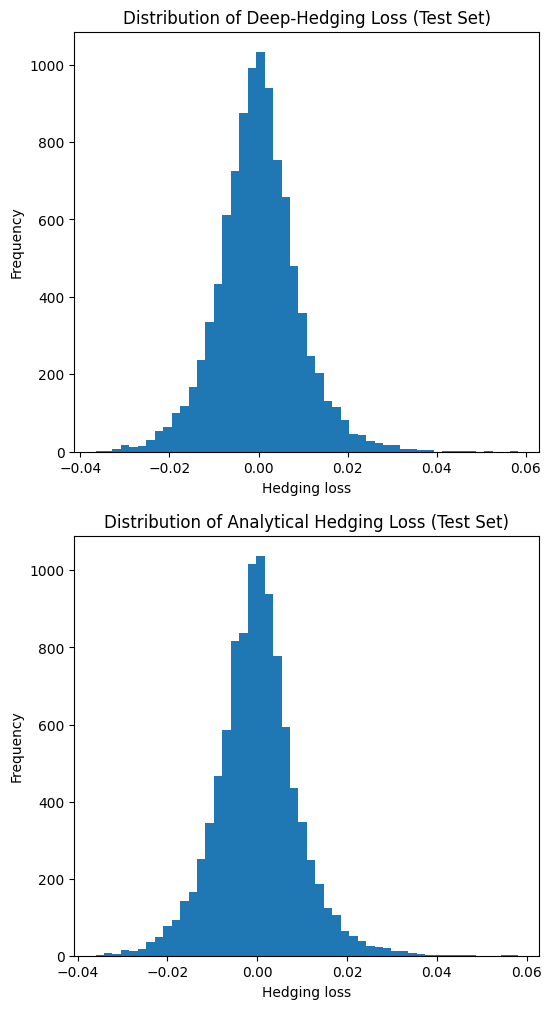

Mean deep hedging loss: -0.000031
Std of deep hedging loss: 0.009136
Mean analytical hedging loss: -0.000039
Std of analytical hedging loss: 0.009044


In [6]:
# Implement the formula you found
def analytical_hedge(n):

    K = 1
    T = 30/365
    sigma = 0.5
    r = 0

    h_bs = []
    for t in range(n):
        tau = T * (1 - t / n)
        d_plus = 1/(sigma*torch.sqrt(torch.tensor(tau))) * (torch.log(test[:,t]/K)+(r + sigma**2/2)*(tau))
        h_bs.append(torch.distributions.Normal(0, 1).cdf(d_plus))
    
    # convert tensor so that each row is one simulated path and the columns correspond to the timesteps.
    h_bs = torch.stack(h_bs, dim=1)
    
    return h_bs

def analytical_loss(H_BS, S, price):
    payoff = call_payoff(S[:, -1])
    hedge_val = torch.sum(H_BS * (S[:, 1:] - S[:, :-1]), dim=1)
    return payoff - price - hedge_val

# Evaluate the losses of the analytical hedging strategies on the test set
H_BS = analytical_hedge(N)

with torch.no_grad():
    loss_analytical = analytical_loss(H_BS, test, rn_price.mean())
# Plot a histograms of the hedging losses (analytical and deep hedging) and print means and standard deviations

fig, axes = plt.subplots(2,1,figsize=(6, 12))

# Plot a histogram of the hedging losses and print mean and standard deviation
axes[0].hist(errors.numpy(), bins=50)
axes[0].set_title("Distribution of Deep-Hedging Loss (Test Set)")
axes[0].set_xlabel("Hedging loss")
axes[0].set_ylabel("Frequency")

axes[1].hist(loss_analytical.numpy(), bins=50)
axes[1].set_title("Distribution of Analytical Hedging Loss (Test Set)")
axes[1].set_xlabel("Hedging loss")
axes[1].set_ylabel("Frequency")

plt.show()

# Compute mean and std
print(f"Mean deep hedging loss: {errors.mean().item():.6f}")
print(f"Std of deep hedging loss: {errors.std().item():.6f}")

print(f"Mean analytical hedging loss: {loss_analytical.mean().item():.6f}")
print(f"Std of analytical hedging loss: {loss_analytical.std().item():.6f}")


How does your deep hedging model compare with the analytical solution? If it's worse, you must improve its performance. A few questions for you to consider...

Have you trained your deep hedging model well?
- Are the losses centered on zero? ($10^{-5} \approx 0$)
- Is their standard deviation comparable with that of the analytical solution?

How can you improve performance?
- train for more epochs
- try a different learning rate
- change the networks' architectures (first try more hidden neurons, then try more hidden layers)
- try different batch sizes
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function (e.g. $\tanh$)
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

### Question 1.g - Learned strategy comparison with analytical solution

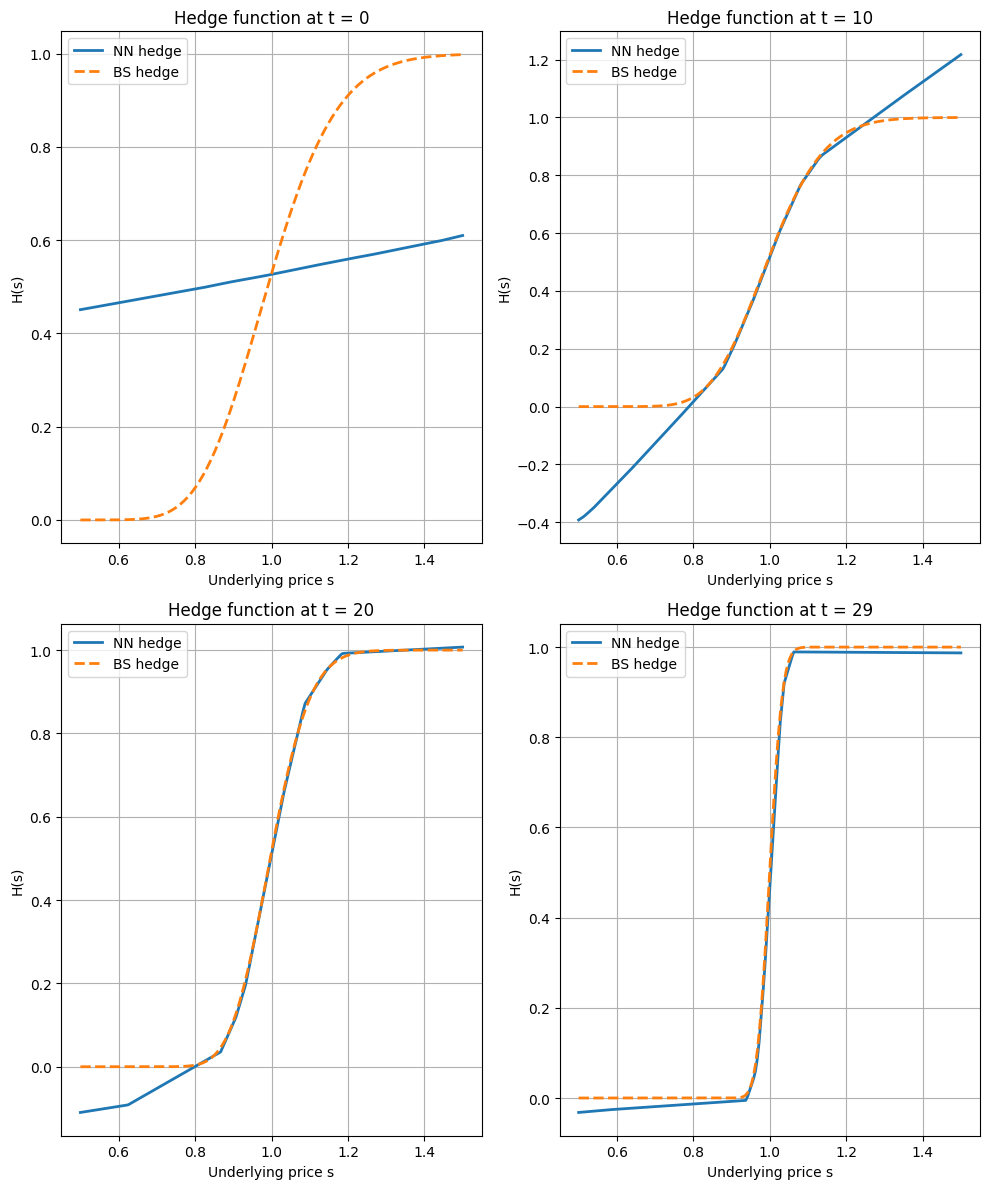

In [18]:

# function to evaluate the model at desired nn and stock price
def network_eval(networks, nn_desired, price):
    
    results = {}
    p = price.unsqueeze(1)

    # evaluate the desired networks and prices
    with torch.no_grad():
        for j in nn_desired:
            net = networks[j]
            results[j] = net(p).squeeze()
    
    return results


def analytical_hedge_test(js, prices):
    K = 1
    T = 30/365
    sigma = 0.5
    r = 0
    N = 30

    results = {}
    s = prices  
    normal = torch.distributions.Normal(0, 1)

    for t in js:
        tau = T * (1 - t/N)
        d_plus = 1/(sigma*torch.sqrt(torch.tensor(tau))) * (torch.log(s/K)+(r + sigma**2/2)*(tau))
        results[t] = normal.cdf(d_plus) 

    return results


# desired networks and prices
j = [0,10,20,29]
s = torch.linspace(0.5, 1.5, 200)

h_nn = network_eval(networks, j, s)

h_analytical = analytical_hedge_test(j,s)

plt.figure(figsize=(10, 12))

for i, t in enumerate(j):
    plt.subplot(2, 2, i+1)
    plt.plot(s, h_nn[t], label="NN hedge", linewidth=2)
    plt.plot(s, h_analytical[t], "--", label="BS hedge", linewidth=2)
    plt.title(f"Hedge function at t = {t}")
    plt.xlabel("Underlying price s")
    plt.ylabel("H(s)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


- For what times $t_j$ are the two functions most similar? 
- Why?

The two functions are most similar for $t_{29}$ because the hedging problem becomes much simpler near maturity.

The loss used to train the hedging networks is

$$
\mathcal{L}
=
\mathbb{E}\left[
\left(
g(S_T)
- p
- \sum_{j=0}^{N-1}
H_{t_j}(S_{t_j})\,
\bigl( S_{t_{j+1}} - S_{t_j} \bigr)
\right)^2
\right].
$$

Although the variance of the increments $S_{t_{j+1}} - S_{t_j}$ is roughly constant across all time steps (because the time grid is uniform), the **structure of the optimal hedge** changes substantially with time.

Near maturity, the option value is almost equal to the payoff, and the Black–Scholes delta becomes nearly deterministic:

$$
H_{\text{BS}}(s,T^-)\approx
\begin{cases}
1, & s > K,\\[4pt]
0, & s < K.
\end{cases}
$$

Because errors in $H_{t_{29}}$ directly affect the final hedging error, the gradient signal for the last network is strong and unambiguous, making this mapping easy for the neural network to learn.

At earlier times, however, many different future price paths are still possible, so the optimal hedge depends on the continuation value and is a much more complex nonlinear function of the state. This makes the early-time networks harder to train.

Therefore, the learned deep hedging strategy matches the analytical Black–Scholes hedge best at $t_{29}$ and progressively worse at earlier times.


# Exercise 2

### Question 2.a - Generate dataset

In [8]:
# Imports
from scipy.stats import ncx2
import numpy as np

In [9]:
# function to compute non-centality parameter
def get_C_j(N, T, alpha_hat, b, v_t, c, n_paths):
    torch.exp(torch.tensor(-alpha_hat*T/N)) * v_t/c
    df = 4*alpha_hat*b/sigma**2
    nc = torch.exp(torch.tensor(-alpha_hat*T/N)) * v_t/c
    C_j = ncx2.rvs(df, nc, size=n_paths)
    return C_j

# Write function to sample V
def generate_V(N, v0, alpha_hat, b, T, Sigma,paths):
    # c_param
    c = Sigma**2/(4*alpha_hat)*(1 - torch.exp(torch.tensor(-alpha_hat*T/N)))
    # initialize Matrix for paths
    V = torch.zeros(paths,N+1)
    V[:,0] = v0
    for i in range(N):
        V[:,i+1] = c * get_C_j(N, T, alpha_hat, b, V[:,i], c, paths)
    
    return V

# Write function to sample S
def generate_S(N, S0, T, V, rho, sigma, alpha_hat, b, paths):
    """
    V : variance paths (paths, N+1)
    """
    dt = T / N

    # iid Gaussian
    Z = torch.randn(paths, N)

    # Storage
    S = torch.zeros(paths, N+1)
    S[:, 0] = S0

    for j in range(N):
        Vj = V[:, j]
        Vj1 = V[:, j+1]

        term1 = (rho / sigma) * ((Vj1 - Vj) - alpha_hat * b * dt)
        term2 = ((alpha_hat * rho) / sigma - 0.5) * Vj * dt
        term3 = torch.sqrt((1 - rho**2) * Vj * dt) * Z[:, j]
        exponent = term1 + term2 + term3

        S[:, j+1] = S[:, j] * torch.exp(exponent)

    return S

# parameters
n = 30
rho = -0.3
alpha_hat = 4
b = 0.5
v0 = 0.5
sigma = 1.0
t = 30/365
# Generate the training set
paths_training = 1e5
V_train = generate_V(n, v0, alpha_hat, b, t, sigma, int(paths_training))
S_train = generate_S(n, 1, t, V_train, rho, sigma, alpha_hat, b, int(paths_training))
heston_dataset_train = TensorDataset(V_train, S_train)
# Generate the test set
paths_test = 1e4
V_test = generate_V(n, v0, alpha_hat, b, t, sigma, int(paths_test))
S_test = generate_S(n, 1, t, V_test, rho, sigma, alpha_hat, b, int(paths_test))
heston_dataset_test = TensorDataset(V_test, S_test)
# check dimesnsions
print(f'training set size: {len(heston_dataset_train)}, test set size: {len(heston_dataset_test)}')


C:\Users\HY\AppData\Local\Temp\ipykernel_21684\3188196856.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  V[:,i+1] = c * get_C_j(N, T, alpha_hat, b, V[:,i], c, paths)


training set size: 100000, test set size: 10000


### Question 2.b - Model implementation

In [10]:
# Implement the deep hedging model for a generic alpha
# number of NN 
N = 30

# Number of neurons in hidden layers
nh1 = 32 # first hidden layer
nh2 = 32 # second hidden layer

# Each network now takes two inputs: S_t and V_t
heston_networks_0_5 = nn.ModuleList([ # alpha  0.5
    nn.Sequential(
        nn.Linear(2, nh1),
        nn.ReLU(),
        nn.Linear(nh1, nh2),
        nn.ReLU(),
        nn.Linear(nh2, 1)
    )
    for _ in range(N)
])

# Each network now takes two inputs: S_t and V_t
heston_networks_0_99 = nn.ModuleList([ # alpha = 0.99
    nn.Sequential(
        nn.Linear(2, nh1),
        nn.ReLU(),
        nn.Linear(nh1, nh2),
        nn.ReLU(),
        nn.Linear(nh2, 1)
    )
    for _ in range(N)
])

### Question 2.c - Model training

In [11]:
# model training helper
def train_heston_models(networks, w, dataloader, loss_fn, optimizer, scheduler, n_epochs, alpha=0.9):
   losses = torch.empty(n_epochs)
   training_loop = tqdm(range(n_epochs)) 
   for epoch in training_loop:
    for V_batch, S_batch in dataloader:
        # compute training loss on batch (now using both V and S)
        loss = loss_fn(V_batch, S_batch, networks, w, alpha)
        # compute gradient of training loss wrt parameters
        loss.backward()
        # do one gradient step
        optimizer.step()
        # reset the computational graph        
        optimizer.zero_grad()
            
        
        # Print loss in the progression bar
        training_loop.set_postfix(loss = loss.item())
        
        # decrease learning rate according to scheduler's settings
        scheduler.step()

        # save training loss for plotting
        losses[epoch] = loss.item()

   price_threshold = w.item() 
   plt.plot(torch.log(losses), label=f'Training loss at alpha={alpha}')
   plt.legend()
   plt.show()

   return price_threshold


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

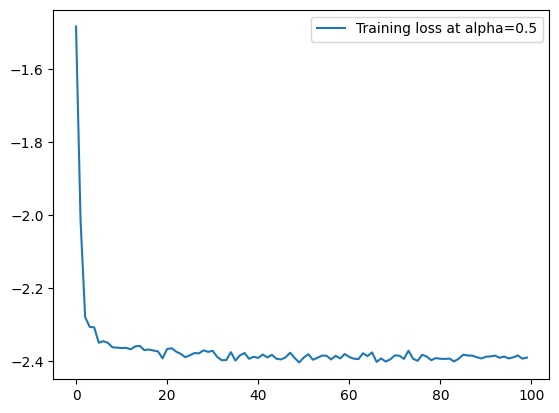

  0%|          | 0/100 [00:00<?, ?it/s]

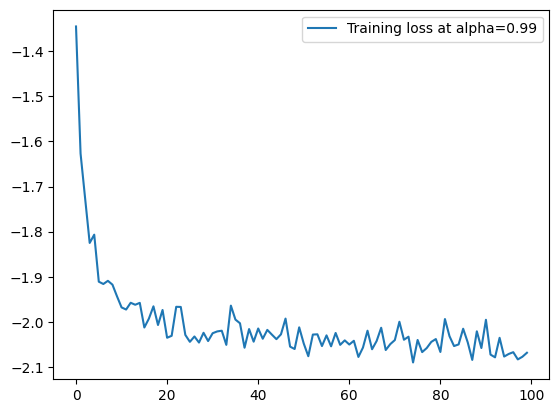

In [12]:
# Train two deep hedging models (for alpha=0.5 and alpha=0.99) for the call option
def heston_loss_fn(V_paths, S_paths, H_list, w, alpha):
    batch_size, N_plus_1 = S_paths.shape
    N = N_plus_1 - 1

    S = S_paths          # (batch, N+1)
    V = V_paths          # (batch, N+1)
    ST = S[:, -1]        # Final price S_T

    # ----- Compute hedge P&L term -----
    # Sum_j H_j(S_j, V_j) * (S_{j+1} - S_j)
    hedge_sum = torch.zeros(batch_size)

    for j in range(N):
        S_j = S[:, j].unsqueeze(1)         # shape (batch, 1)
        V_j = V[:, j].unsqueeze(1)         # shape (batch, 1)

        # Concatenate S and V as inputs to the network
        input_j = torch.cat([S_j, V_j], dim=1)  # shape (batch, 2)
        H_j = H_list[j](input_j).squeeze(1)     # shape (batch,)   network output

        dS = S[:, j+1] - S[:, j]           # shape (batch,)
        hedge_sum += H_j * dS

    # ----- Loss variable X -----
    # X = payoff - hedge P&L
    X = call_payoff(ST) - hedge_sum   # shape (batch,)

    # ----- CVaR loss -----
    loss = w + (1.0 / (1 - alpha)) * torch.relu(X - w)
    loss = loss.mean()

    return loss

# Define training hyperparameters
n_epochs = 100
lr = 1e-2 # learning rate
batch_size = 1000
milestones = [75]

# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
w1 = torch.nn.Parameter(torch.tensor(1.0))
w2 = torch.nn.Parameter(torch.tensor(1.0))
optimizer_0_5 = torch.optim.Adam(list(heston_networks_0_5.parameters()) + [w1], lr=lr)
optimizer_0_99 = torch.optim.Adam(list(heston_networks_0_99.parameters()) + [w2], lr=lr)
# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler_0_5 = torch.optim.lr_scheduler.MultiStepLR(optimizer_0_5, milestones=milestones, gamma=0.1)
scheduler_0_99 = torch.optim.lr_scheduler.MultiStepLR(optimizer_0_99, milestones=milestones, gamma=0.1)
# Create a batch loader from the dataset
heston_loader = DataLoader(heston_dataset_train, batch_size=batch_size, shuffle=True)

losses = torch.empty(n_epochs)
training_loop = tqdm(range(n_epochs)) 

# for epoch in training_loop:
#         
#         # At each epoch iterate over batches
#         for V_batch, S_batch in heston_loader:
#             # compute training loss on batch (now using both V and S)
#             loss = heston_loss_fn(V_batch, S_batch, heston_networks, w, alpha=0.95)
#             # compute gradient of training loss wrt parameters
#             loss.backward()
#             # do one gradient step
#             optimizer.step()
#             # reset the computational graph        
#             optimizer.zero_grad()
#             
#         
#         # Print loss in the progression bar
#         training_loop.set_postfix(loss = loss.item())
#         
#         # decrease learning rate according to scheduler's settings
#         scheduler.step()
# 
#         # save training loss for plotting
#         losses[epoch] = loss.item()
# 
# plt.plot(torch.log(losses), label='Training loss')
# plt.legend()
# plt.show()

price_0_5 = train_heston_models(heston_networks_0_5, w1, heston_loader, heston_loss_fn, optimizer_0_5, scheduler_0_5, n_epochs, alpha=0.5)
price_0_99 = train_heston_models(heston_networks_0_99, w2, heston_loader, heston_loss_fn, optimizer_0_99, scheduler_0_99, n_epochs, alpha=0.99)

### Question 2.d - Price comparison

In [13]:
# Print the prices p for alpha=0.5 and alpha=0.99
# Which one is higher? Why? 

print(f"Estimated price for alpha=0.5: {price_0_5:.6f}")
print(f"Estimated price for alpha=0.99: {price_0_99:.6f}")

Estimated price for alpha=0.5: 0.079049
Estimated price for alpha=0.99: 0.120643


With α = 0.99, CVaR computes the average of the worst 1% of hedging losses, so only the extreme tail of the loss distribution matters.
With α = 0.5, CVaR averages the worst 50% of losses, so milder losses are also included.
Therefore alpha = 0.99 is more conservative and leads to a more expensive hedge and a higher option price.

### Question 2.e - Price comparison

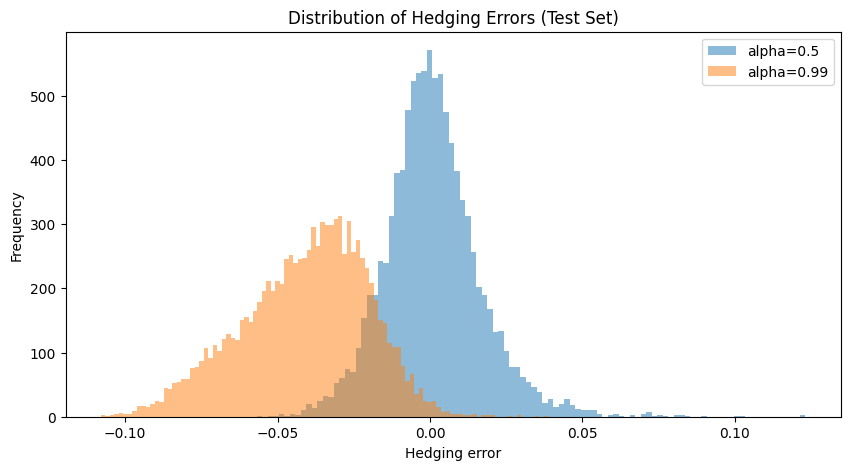

alpha=0.5: mean error=0.000877, std=0.015681, mean squared loss=0.000247
alpha=0.99: mean error=-0.040912, std=0.020469, mean squared loss=0.002093


In [14]:
# Plot a histograms of the hedging losses (for alpha=0.5 and alpha=0.99) and print means and standard deviations
# Plot histograms of the hedging losses (for alpha=0.5 and alpha=0.99)
def hedge_sum_heston(networks, V, S):
    # Computes sum_j H_j(S_j, V_j) * (S_{j+1} - S_j)
    hedge = torch.zeros(S.shape[0])
    for j, net in enumerate(networks):
        S_j = S[:, j].unsqueeze(1)
        V_j = V[:, j].unsqueeze(1)
        inp = torch.cat([S_j, V_j], dim=1)
        Hj = net(inp).squeeze(1)
        hedge += Hj * (S[:, j+1] - S[:, j])
    return hedge

with torch.no_grad():
    # Hedging and errors for alpha=0.5 model
    hedge_0_5 = hedge_sum_heston(heston_networks_0_5, V_test, S_test)
    errors_0_5 = call_payoff(S_test[:, -1]) - price_0_5 - hedge_0_5

    # Hedging and errors for alpha=0.99 model
    hedge_0_99 = hedge_sum_heston(heston_networks_0_99, V_test, S_test)
    errors_0_99 = call_payoff(S_test[:, -1]) - price_0_99 - hedge_0_99

    # Squared losses
    losses_0_5 = errors_0_5**2
    losses_0_99 = errors_0_99**2

# Plot histograms (overlayed)
plt.figure(figsize=(10,5))
plt.hist(errors_0_5.numpy(), bins=100, alpha=0.5, label='alpha=0.5')
plt.hist(errors_0_99.numpy(), bins=100, alpha=0.5, label='alpha=0.99')
plt.title('Distribution of Hedging Errors (Test Set)')
plt.xlabel('Hedging error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"alpha=0.5: mean error={errors_0_5.mean().item():.6f}, std={errors_0_5.std().item():.6f}, mean squared loss={losses_0_5.mean().item():.6f}")
print(f"alpha=0.99: mean error={errors_0_99.mean().item():.6f}, std={errors_0_99.std().item():.6f}, mean squared loss={losses_0_99.mean().item():.6f}")